## **Gaussian Naive Bayes: Implementation**

### **Parameterization** 


Here the features have real numbers or continuous values. And we assume that **each feature given label is drawn from a Gaussian distribution.** 

Formally we write it as :
$$ 
x_j|y_r   \sim   \mathcal{N} (\mu , \sigma^2)
$$

* There are two parameters in Gaussian or normal distribution $\math cal{N} :
  * Mean $ \mu $
  
  * Variance $ \sigma^2 $


* There are $ m \times k $ **Gaussian distribution** - one for each feature and label.

* Each Gaussian distribution has 2 parameters to estimate hence the **total number of parameters** are $2 \times m \times k$.

### **Alternate parameterization through multi-variate Gaussian**

Alternatively, for each label, we can assume a multi-variate Gaussian distribution with $ m $ variables.

Such a distribution will have :

* a **mean vector** $(\mu)$ with $m$ components - one mean per feature.

* a **covariance matrix** $(\sum ) \text{with} m\times m $ entries :

  * However since we are making a conditional independence assumption among variables, the covariance matrix is assumed to be diagonal.

  * It's off-diagonal entries are $ 0$ i.e 
\begin{align}
\sum_{jr}=0 \ \text {where} \ j \ne r.
\end{align}
  
  * The diagonal entries denote variance for each feature i.e
\begin{align}
\sum_{jj}= \sigma^2.
\end{align}

In this scheme, we need to estimate $k $ multi-variate Gaussian distributions, one per label.

For each distribution, we need to estimate
* $m$ means

* $m$ variances

As such a number of parameters are the same in both the representation. However the later representation is more efficient in terms of computation.

### **Parameter estimation**

Let **$ n_r $ the total number of samples with label** $y_r$.
$$ n_r = \sum \limits_{i=1}^n \mathbb{1}(y^{(i)}=y_r) $$

The parameters for **multivariate Gaussian** for label $r$ can be calculated as follows:

\begin{align} 
\mu_r &=&\frac{1}{n_r}\sum \limits_{i=1}^n 1(y^{(i)}=y_r) \mathbf x^{(i)} 
\end{align}

\begin{align}
\\ {{\sum}_{jjr}^2}&=&\frac{1}{n_r}\sum \limits_{i=1}^n 1(y^{(i)}=y_r)(\mathbf x^{(i)}-\mu_r)^2 \\
\end{align}

### **Inference** 

The posterior probability can be  calculated based on Bayes theorem :
$$ p(y=y_c | \mathbf x) = \frac{p(\mathbf x| y_c) \ p(y_c)}{p(y_c)}$$

The likelihood is computed with following formula:
$$ p(x_j|y_c; \mu_{jc},\sigma_{jc}^2)=\frac{1}{\sqrt {2 \pi} \sigma_{jc}} e^{- \frac{1}{2} \left(\frac{x_j-\mu_{jc}}{\sigma{jc}} \right)^2}$$

This can be implemented with multi-variate Gaussian distribution with diagonal covariance matrix:
$$ p(x_j|y_c; \mu_{jc},{\sum}_c)=\frac{1}{{(2\pi)}^{\frac{d}{2}} |{\sum}_c|^{\frac{1}{2}}}e^{-\frac{1}{2}}(\mathbf x -\mu_c)^T \small \small {\small {\sum}_c^{-1}}(\mathbf x -\mu_c)$$ 

It is interesting to note that : 
* We calculate the distance between the mean and the sample normalized by the variance : 

\begin{align}
{-\frac{1}{2}}(\mathbf x -\mu_c)^T \small \small {\small {\sum}_c^{-1}}(\mathbf x -\mu_c)
\end{align}

* We calculate exponential of this distance and convert it into probability by dividing it with : 

\begin{align}
{{(2\pi)}^{\frac{d}{2}} |{\sum}_c|^{\frac{1}{2}}}
\end{align}

* Derived formula for probablity of a multi-variate Gaussian distribution is :

\begin{align}
\frac{{-\frac{1}{2}}(\mathbf x -\mu_c)^T \small \small {\small {\sum}_c^{-1}}(\mathbf x -\mu_c)} {{(2\pi)}^{\frac{d}{2}} |{\sum}_c|^{\frac{1}{2}}}
\end{align}

In [1]:
import numpy as np 

class GaussianNB(object):
    def fit(self, X, y):
        '''parameter estimation for gaussian distribution'''
        n_samples, n_features = X.shape

        self._classes = np.unique(y)
        n_classes = len(self._classes)

    # calculate mean, var, and prior for each class.

        self._mean = np.zeros((n_classes, n_features), dtype=np.float64)
        self._var = np.zeros((n_classes, n_features), dtype=np.float64)
        self._priors = np.zeros(n_classes, dtype=np.float64)

        for idx, c in enumerate(self._classes):
            # Get examples with label $c$
            X_c = X[y == c]

            # estimate mean from the training examples of class $c$
            self._mean[idx, :] = X_c.mean(axis=0)

            # estimate variance from the training examples of class $c$.
            self._var[idx, :] = X_c.var(axis=0)

            # estimate the priors - based on fraction of examples with label c among all the training examples.

            self._priors[idx] = X_c.shape[0]/float(n_samples)

        print('Mean :\n', self._mean)
        print()
        print('Variance :\n', self._var)
        print()
        print('Priors :', self._priors)

    def _calc_pdf(self, class_idx, X):
        ''' calculates probability density for samples for class label class_idx.'''

        mean = self._mean[class_idx]
        var = np.diag(self._var[class_idx])
        z = np.power(2*np.pi, X.shape[0]/2)*np.power(np.linalg.det(var), 1/2)

        return (1/z)*np.exp(-(1/2)*(X-mean).T@(np.linalg.inv(var))@(X-mean))

    def _calc_prod_likelihood_prior(self, X):
        ''' calculates product of likelihood and priors.'''

        self._prod_likelihood_prior = np.zeros(
            (X.shape[0], len(self._classes)), dtype=np.float64)

        for x_idx, x in enumerate(X):
            for idx, c in enumerate(self._classes):
                self._prod_likelihood_prior[x_idx, c] = (
                np.log(self._calc_pdf(idx, x)) + np.log(self._priors[idx]))

    def predict(self, X):
        ''' predict class labels for each example'''

        self._calc_prod_likelihood_prior(X)
        return np.argmax(self._prod_likelihood_prior, axis=1)

    def predict_proba(self, X):
        ''' calculates probability of each example belonging to different classes.'''

        self._calc_prod_likelihood_prior(X)
        return np.exp(self._prod_likelihood_prior)/np.expand_dims(np.sum(np.exp(self._prod_likelihood_prior), axis=1), axis=1)

#### **Demonstration**

We will demonstrate working on least square classification in the following set ups:
1. Binary classification set up.

2. Multi-class classification set up

#### DEMO 1 : *Binary classification* 

* Generates examples from two classes.

* Divide the data into train and test split.

* Train the model on the examples from training set.

* Evaluate the classification performation on the test set.

##### **STEP 1** : Generate training data with two multi-variate Gaussian distribution one with mean \[5, 5\] and the second one with mean \[10, 10\] and standard deviation 1.5 for each Gaussian.

* The number of features per example = 2 

* Total number of examples =100

In [2]:
from sklearn.datasets import make_classification, make_blobs
from sklearn.model_selection import train_test_split

X, y = make_blobs(n_samples=100,
                  n_features=2,
                  centers=[[5, 5], [10, 10]],
                  cluster_std=1.5,
                  random_state=2)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

##### **STEP 2** : Train the naive bayes classifier.

In [3]:
gaus_nb =GaussianNB()
gaus_nb.fit(X_train,y_train)

Mean :
 [[ 4.55853975  5.01739665]
 [10.30431548 10.08580617]]

Variance :
 [[2.13298417 2.30222002]
 [3.22242307 2.20662074]]

Priors : [0.5125 0.4875]


Observe that since each examples has two features and we have two classes, we have :

* Mean vector for each class has two components-mean for feature 1 and feature 2.

* Variance also has two entries-one for variance of feature 1 and feature 2. 

**Note** : 
We are only storing the diagonal elements of covariance matrix for each class label.

There are two priors - one for each class.

* Since we are performing parameter estimation on examples generated from the known distributions, we can compare estimated means with the actual means.

* One distribution has mean close to \[5,5\] and the other one has mean close to \[10,10\] which are **very close to the actual means**.

<Figure size 864x576 with 0 Axes>

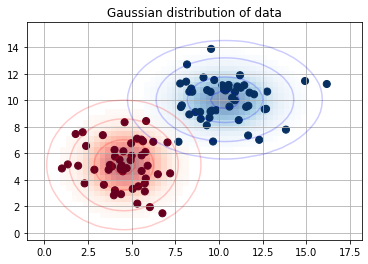

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,8))
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')

xlim = (min(X[:, 0])-2, max(X[:, 0])+2)
ylim = (min(X[:, 1])-2, max(X[:, 1])+2)

xg = np.linspace(xlim[0], xlim[1], 60)
yg = np.linspace(ylim[0], ylim[1], 40)

xx, yy = np.meshgrid(xg, yg)
Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T


for label, color in enumerate(['red', 'blue']):
    mask = (y == label)
    mu, std = X[mask].mean(0), X[mask].std(0)
    P = np.exp(-0.5 * (Xgrid - mu)**2 / std**2).prod(1)
    Pm = np.ma.masked_array(P, P < 0.03)
    ax.pcolorfast(xg, yg, Pm.reshape(xx.shape),
                alpha=0.5, cmap=color.title()+'s')
    ax.contour(xx, yy, P.reshape(xx.shape), levels=[
                0.01, 0.1, 0.5, 0.9], colors=color, alpha=0.2)

ax.set(xlim=xlim, ylim=ylim)
plt.grid()
plt.title("Gaussian distribution of data")
plt.show()

##### **STEP 4**: Let's test the inference procedure on the test data.

Let's get class predictions for the test examples.

In [5]:
gaus_nb.predict(X_test)

array([0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
      dtype=int64)

Generate the classification report-containing information about different classification evaluation metrics like precision, recall, F1-score and accuracy.

In [6]:
from sklearn.metrics import classification_report 
print(classification_report(y_test,gaus_nb.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        11

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



Let's get probability of each example belong to each class.

In [7]:
gaus_nb.predict_proba(X_test)

array([[9.99999746e-01, 2.54140753e-07],
       [7.63749214e-14, 1.00000000e+00],
       [4.23038642e-03, 9.95769614e-01],
       [9.99986614e-01, 1.33855473e-05],
       [7.05769182e-06, 9.99992942e-01],
       [9.99820566e-01, 1.79433743e-04],
       [9.72541524e-01, 2.74584756e-02],
       [9.99982043e-01, 1.79572091e-05],
       [2.85910189e-05, 9.99971409e-01],
       [1.01888837e-07, 9.99999898e-01],
       [7.39129058e-01, 2.60870942e-01],
       [9.99793438e-01, 2.06561658e-04],
       [9.99999915e-01, 8.46737165e-08],
       [2.03213294e-05, 9.99979679e-01],
       [8.76198350e-09, 9.99999991e-01],
       [6.51163513e-05, 9.99934884e-01],
       [9.27638525e-05, 9.99907236e-01],
       [7.58034673e-09, 9.99999992e-01],
       [1.81773339e-03, 9.98182267e-01],
       [9.99985544e-01, 1.44557945e-05]])

Let's make a prediction for new data point.

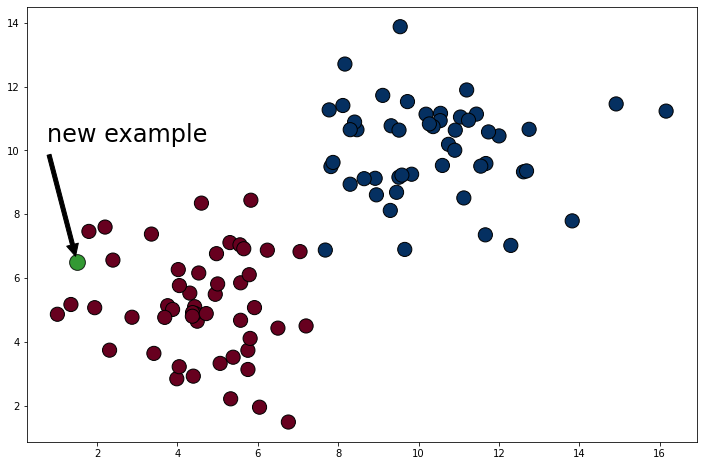

In [8]:
x_new = np.array([1.5, 6.5])

plt.figure(figsize=(12, 8))
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y,
            s=200, edgecolor='k', cmap='RdBu')

plt.scatter(x_new[0], x_new[1], marker='o', c='green',
            s=250, edgecolor='k', alpha=0.8)

plt.annotate('new example', xy=x_new, xytext=(-30, 120), textcoords='offset points',
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=24)
plt.show()


Since the data point is close to Gaussian distribution with mean [5,5], it will get label of that class.

In [9]:
gaus_nb.predict_proba(np.array([x_new]))

array([[9.99996296e-01, 3.70449944e-06]])

Observe that the probability of the new example belonging to class 0, which has mean of [5,5], is 0.99, which is much larger than the other class and hence it is assigned class label of 0.

#### DEMO 2 : *Multi-class classification*

Our implementation also works for multi-class case.
* We generate 100 examples from three classes with means $[5,5],[10,10],[20,20]$.

* Each example has two features.

In [10]:
# generate synthetic dataset with three classes.
# Each example is represented with two features.

X,y = make_blobs(n_samples =100,
                 n_features=2,
                 centers=[[5,5],[10,10],[20,20]],
                 cluster_std=1.5,
                 random_state=3)

X_train, X_test, y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=123)

Let's estimate the parameters of Gaussian distributions.

In [11]:
gaus_nb_multiclass = GaussianNB()
gaus_nb_multiclass.fit(X_train,y_train)

Mean :
 [[ 4.94844927  4.67947138]
 [ 9.62097704 10.49990402]
 [19.63832097 19.94706375]]

Variance :
 [[1.99332345 2.36976247]
 [1.68415535 2.25596351]
 [1.79203315 1.24939267]]

Priors : [0.3375 0.35   0.3125]


Let's use the estimated parameters to make prediction on test examples and generate a classification evaluation report.

In [12]:
print(classification_report(y_test, gaus_nb_multiclass.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         8

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



Finally predict probability of each test example belonging to the three different classes.

In [13]:
gaus_nb_multiclass.predict_proba(X_test)

array([[1.02996770e-47, 2.67740135e-24, 1.00000000e+00],
       [5.00111567e-05, 9.99949989e-01, 6.51529293e-32],
       [9.99999999e-01, 9.45325297e-10, 1.33290144e-78],
       [1.00000000e+00, 6.49743430e-12, 7.70260328e-90],
       [1.50617094e-52, 5.94123831e-27, 1.00000000e+00],
       [3.77917160e-47, 9.99218112e-23, 1.00000000e+00],
       [5.30598294e-33, 9.05195020e-13, 1.00000000e+00],
       [6.63950534e-07, 9.99999336e-01, 1.42699786e-26],
       [3.57244754e-61, 3.86494439e-34, 1.00000000e+00],
       [9.70872284e-06, 9.99990291e-01, 5.02104511e-31],
       [9.99982252e-01, 1.77477098e-05, 2.51366893e-63],
       [3.93493321e-39, 5.51495730e-18, 1.00000000e+00],
       [1.00000000e+00, 4.72574372e-11, 1.19906531e-79],
       [1.19575291e-47, 3.45203067e-24, 1.00000000e+00],
       [9.09245241e-01, 9.07547595e-02, 1.30885257e-46],
       [9.99999997e-01, 2.64110663e-09, 3.37901343e-80],
       [9.97572472e-01, 2.42752753e-03, 1.17514148e-55],
       [1.12896485e-05, 9.99988